In [1]:
%%javascript
/*
    go to the project directory
*/
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;

var path = attribs['data-notebook-path'].value
console.log('path',path)
var command = "cd  /" + path.substring(0, path.lastIndexOf("/"));
console.log('command', command)

kernel.execute(command)

<IPython.core.display.Javascript object>

In [2]:
import random
import argparse
import torch
import torch.nn.functional as F
from torch import nn
from torchtext import data, vocab
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score
from helpers import *
from Models import *
torch.manual_seed(1337)
random.seed(13370)


A:\Users\skjal\Miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--train', action='store', default="./nli5550/nli5550.test.jsonl")
    #parser.add_argument('--dev', action='store', default="./nli5550/nli5550.dev.jsonl")
    #parser.add_argument('--embeds', action='store', default=None)
    #parser.add_argument('--batch_size', action='store', default=32)
    #parser.add_argument('--lr', action='store', default=1e-3)
    #parser.add_argument('--epochs', action='store', default=10)
    #parser.add_argument('--name', action='store', default="MODEL_NAME")
    #parser.add_argument('--encoder', action='store', default="sentenceEmbedding", choices=["sentenceEmbedding", 'convNet'])
    #args = parser.parse_args()
    
args = argparse.Namespace()
args.train = "nli5550/nli5550.train.jsonl"
args.dev = "nli5550/nli5550.dev.jsonl"
args.batch_size = 32
args.lr = 1e-3
args.epochs = 10
args.name = 'testing-rnnr'
args.encoder = "sentenceEmbedding" 
#args.encoder = 'convNet'
args.split = 0.1
args.embeds = None

In [5]:
try:
    from tensorboardX import SummaryWriter
    writer = SummaryWriter('./runs/{}'.format(args.name))
except ImportError:
    writer = None

In [6]:

token_field = data.Field(sequential=True, batch_first=True, include_lengths=True, 
                         tokenize=lambda x: x.split(), preprocessing=lambda x: x[1].split())
label_field = data.Field(sequential=False, batch_first=True, preprocessing=lambda x: x[1])
NaF = ('none', None)

fields = [
            NaF, #('annotator_labels', label_field), 
            NaF, # captionID
            ('gold_label', label_field), 
            NaF, # pairID
            NaF, #('sentence1', token_field),
            NaF, #('sentence1_parse', token_field),
            NaF, #('sentence2', token_field),
            NaF, #('sentence2_parse', token_field),
            ('sentence1_tok', token_field),
            ('sentence2_tok', token_field)
        ]


In [7]:
def train(model, iterator, criterion, optimiser, epoch, writer=None):
    
    model.train()
    pbar = tqdm(total=len(iterator.data()))
    pbar.set_description('Train')
    accuracy, total = 0, 0
    total_loss = 0
    iterator.init_epoch()
    for n, batch in enumerate(iterator):
        optimiser.zero_grad()
        
        predictions = model(batch)
        gold = batch.gold_label
        loss = criterion(predictions, gold) + model.encoder.P
        
        predmax = predictions.argmax(dim=-1)
        total_loss += loss.item()
        accuracy += ( predmax== gold).nonzero().size(0)
        total += predmax.size(0)
        
        loss.backward()
        optimiser.step()
        pbar.update( len(batch) ) # batch_size
        pbar.set_postfix(loss=loss.item())
        if writer is not None: writer.add_scalar('Train/Loss', loss.item(), n)
        
    if writer is not None: writer.add_scalar('Train/total_loss', total_loss, epoch)
    if writer is not None: writer.add_scalar('Train/mean_loss', total_loss/total, epoch)
    if writer is not None: writer.add_scalar('Train/accuracy', accuracy/total, epoch)
    
    pbar.close()

def evaluate(model, iterator, epoch, writer=None):
    model.eval()
    accuracy, total = 0, 0
    
    pbar = tqdm(total=len(iterator.data()))
    pbar.set_description('Evaluate')
    for n, batch in enumerate(iterator):
        predictions = model(batch).argmax(dim=-1)
        gold = batch.gold_label
        accuracy += (predictions == gold).nonzero().size(0)
        total += predictions.size(0)
        
        pbar.update( len(batch) ) # batch_size
        pbar.set_postfix(accuracy=accuracy/total)
        
    if writer is not None: writer.add_scalar('Dev/accuracy', accuracy/total, epoch)
    print("> dev accuracy: {}/{} = {}".format(accuracy, total, accuracy/total))
    pbar.close()

In [8]:
train_dataset = data.Dataset( load_jsonl_examples(args.train, fields) , fields=fields).split(args.split)[0]
dev_dataset = data.Dataset( load_jsonl_examples(args.dev, fields) , fields=fields)

In [9]:
print( 'train_dataset lenght:\t{}'.format(len(train_dataset)))
print( 'dev_dataset lenght:\t{}'.format(len(dev_dataset)))

train_dataset lenght:	55015
dev_dataset lenght:	10000


In [10]:
if args.embeds is not None:
    _vecs = vocab.Vectors(args.embeds)
else:
    _vecs = "glove.6B.100d"

token_field.build_vocab(train_dataset, vectors=_vecs)
label_field.build_vocab(train_dataset)

In [11]:
train_iter = data.Iterator(train_dataset, batch_size=args.batch_size, train=True, sort=True, repeat=False, 
                            sort_key=lambda x: (len(x.sentence1_tok)+len(x.sentence1_tok))/2)
dev_iter = data.Iterator(dev_dataset, batch_size=1, train=False, sort=False)

In [29]:
help(label_field.vocab.freqs)

Help on Counter in module collections object:

class Counter(builtins.dict)
 |  Counter(*args, **kwds)
 |  
 |  Dict subclass for counting hashable items.  Sometimes called a bag
 |  or multiset.  Elements are stored as dictionary keys and their counts
 |  are stored as dictionary values.
 |  
 |  >>> c = Counter('abcdeabcdabcaba')  # count elements from a string
 |  
 |  >>> c.most_common(3)                # three most common elements
 |  [('a', 5), ('b', 4), ('c', 3)]
 |  >>> sorted(c)                       # list all unique elements
 |  ['a', 'b', 'c', 'd', 'e']
 |  >>> ''.join(sorted(c.elements()))   # list elements with repetitions
 |  'aaaaabbbbcccdde'
 |  >>> sum(c.values())                 # total of all counts
 |  15
 |  
 |  >>> c['a']                          # count of letter 'a'
 |  5
 |  >>> for elem in 'shazam':           # update counts from an iterable
 |  ...     c[elem] += 1                # by adding 1 to each element's count
 |  >>> c['a']                          

In [31]:
help(dev_iter.data())

Help on Dataset in module torchtext.data.dataset object:

class Dataset(torch.utils.data.dataset.Dataset)
 |  Dataset(examples, fields, filter_pred=None)
 |  
 |  Defines a dataset composed of Examples along with its Fields.
 |  
 |  Attributes:
 |      sort_key (callable): A key to use for sorting dataset examples for batching
 |          together examples with similar lengths to minimize padding.
 |      examples (list(Example)): The examples in this dataset.
 |      fields (dict[str, Field]): Contains the name of each column or field, together
 |          with the corresponding Field object. Two fields with the same Field object
 |          will have a shared vocabulary.
 |  
 |  Method resolution order:
 |      Dataset
 |      torch.utils.data.dataset.Dataset
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getattr__(self, attr)
 |  
 |  __getitem__(self, i)
 |  
 |  __init__(self, examples, fields, filter_pred=None)
 |      Create a dataset from a list of Examples

In [52]:


for i, b in enumerate(dev_iter):
    b.gold_label
    print(b.__dict__)
    if i > 5: break
        

{'batch_size': 1, 'dataset': <torchtext.data.dataset.Dataset object at 0x000002980CA86588>, 'fields': dict_keys(['none', 'gold_label', 'sentence1_tok', 'sentence2_tok']), 'input_fields': ['gold_label', 'sentence1_tok', 'sentence2_tok'], 'target_fields': [], 'gold_label': tensor([3]), 'sentence1_tok': (tensor([[  21,   54,   12, 2406,   26,   45,   17,  493, 5055,    2]]), tensor([10])), 'sentence2_tok': (tensor([[  14, 1323,   12,  700,    0,   26,   45,   17,  493, 5055,  279,  385,
          139,  449,    2]]), tensor([15]))}
{'batch_size': 1, 'dataset': <torchtext.data.dataset.Dataset object at 0x000002980CA86588>, 'fields': dict_keys(['none', 'gold_label', 'sentence1_tok', 'sentence2_tok']), 'input_fields': ['gold_label', 'sentence1_tok', 'sentence2_tok'], 'target_fields': [], 'gold_label': tensor([1]), 'sentence1_tok': (tensor([[  21,   54,   12, 2406,   26,   45,   17,  493, 5055,    2]]), tensor([10])), 'sentence2_tok': (tensor([[  21,   16,   12,   45, 5055,    2]]), tensor([6]

In [13]:
%load_ext autoreload

In [14]:
%autoreload 2

In [38]:
if args.encoder == 'sentenceEmbedding':
    encoder = sentenceEmbeddingEncoder(token_field.vocab)
elif args.encoder == 'convNet':
    encoder = convNetEncoder(token_field.vocab)

# classifier model MLP_classifier
net = MLP_classifier(token_field.vocab, label_field.vocab, encoder)

In [43]:

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(net.parameters(), lr=args.lr)


for epoch in range(args.epochs):
    train(net, train_iter, criterion, optimiser, epoch, writer)
    evaluate(net, dev_iter, epoch, writer)


26530057


KeyboardInterrupt: 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [94]:
a = torch.ones(2, 2)
if len(a.shape) == len((2,2)): print('i am here')

i am here


In [88]:
a = 'BILSTM'
if 'bi' in a.lower():
    print('yes')

yes


In [ ]:

self.MLP = nn.Sequential(nn.Linear( self.encoder.output_size*4, hidden_size ), # input layer
                         nn.ReLU(), # hidden layer
                         nn.Linear(hidden_size, len(tag_vocab))) # ouput layer

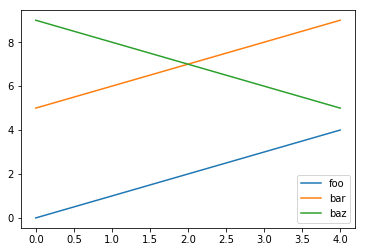

In [33]:
import matplotlib.pyplot as plt

x = [0, 1, 2, 3, 4]
y = [ [0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [9, 8, 7, 6, 5] ]
labels = ['foo', 'bar', 'baz']

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.legend()
plt.show()

In [ ]:
#tensorboard.notebook.start('--logdir ./runs')
#http://www.erogol.com/use-tensorboard-pytorch/#viewSource

NameError: name 'encoder' is not defined

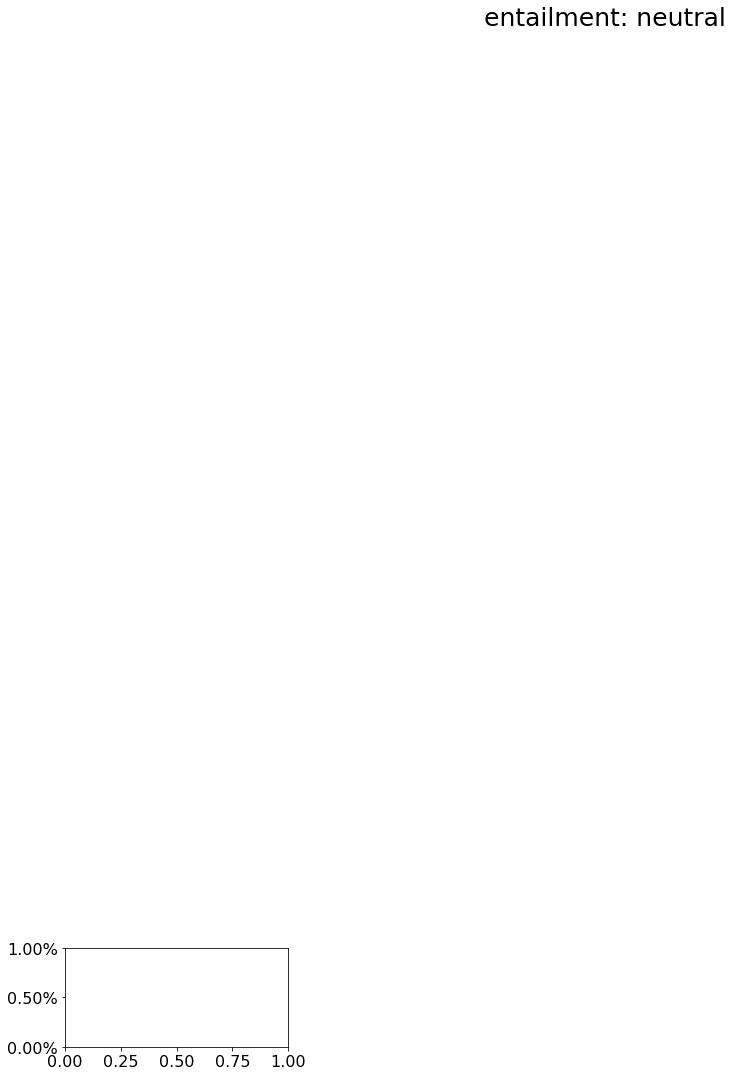

In [32]:

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

for example, data in zip(dev_iter, dev_iter.data()):

    fig = plt.figure(1, figsize=(4,4))
    fig.suptitle("entailment: {}".format(data.gold_label), x=2,y=4.15, fontsize=25)
    plt.rcParams.update({'font.size': 16})
    fig.patch.set_facecolor('white')
    
    sentence1 = plt.subplot(211)
    sentence1.yaxis.set_major_formatter(mtick.PercentFormatter())
    _, A = encoder.visualizeExmaple(example.sentence1_tok)
    A = torch.squeeze(A).mean(0)
    plt.bar(data.sentence1_tok, (A).detach().numpy()*100)
    
    
    sentence2 = plt.subplot(212)
    _, A = encoder.visualizeExmaple(example.sentence2_tok)
    A = torch.squeeze(A).mean(0)
    plt.bar(data.sentence2_tok, (A).detach().numpy()*100)
    sentence2.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.subplots_adjust(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0.1)
    break
    